# Installation

In [ ]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
!pip install --upgrade git+git://github.com/frehseg/nvcc4jupyter.git

  Cloning git://github.com/frehseg/nvcc4jupyter.git to /tmp/pip-req-build-_jtw493i
  Running command git clone -q git://github.com/frehseg/nvcc4jupyter.git /tmp/pip-req-build-_jtw493i
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.1-cp36-none-any.whl size=2095 sha256=3da9d0b8c49834ec62bf5ec9289cb214d4eadeaf3110595c7c0d3981ec8b7eba
  Stored in directory: /tmp/pip-ephem-wheel-cache-ipkqlm41/wheels/a4/a5/24/17a2b61f9a725a10155cc6fca753aae28436921df21fa16114
Successfully built NVCCPlugin


In [ ]:
%load_ext nvcc_plugin

Based on the lecture:


# Code

## CUDA Utilities

In [ ]:
%%writefile cuda_stuff.cuh
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>

#ifndef cuda_stuff_H
#define cuda_stuff_H

/* transform matrix index to vector offset
   Since CUDA uses column major, 
   nb_rows = number of rows */
#define IDX2C(i,j,nb_rows) (((j)*(nb_rows))+(i))
 
//MACRO TO DEBUGG CUDA FUNCTIONS
/** Error checking,
 *  taken from https://stackoverflow.com/questions/14038589/what-is-the-canonical-way-to-check-for-errors-using-the-cuda-runtime-api
 */
#define gpuErrchk(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess) 
   {
      fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}
/** Error checking for use with CUDA Dynamic Parallelism */
/*
#define cdpErrchk(ans) { cdpAssert((ans), __FILE__, __LINE__); }
__device__ void cdpAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess)
   {
      printf("GPU kernel assert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) assert(0);
   }
}
*/
void device_synchronize();

#endif


Writing cuda_stuff.cuh


In [ ]:
%%writefile cuda_stuff.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>
#include "cuda_stuff.cuh"

void device_synchronize(){
    gpuErrchk(cudaDeviceSynchronize());
}

Writing cuda_stuff.cu


## fmatrix Matrix Tools

In [ ]:
%%writefile fmatrix.cuh
#ifndef fmatrices_H
#define fmatrices_H
#include "cuda_stuff.cuh" // for IDX2C

typedef struct {
    float* data;
    int cols;
    int rows;
} fmatrix;

/* Access element (i,j) of matrix mat */
#define getfm(mat,i,j) (mat.data[IDX2C(i,j,mat.rows)])


int fmatrix_elements(fmatrix mat);
int fmatrix_size(fmatrix mat);
/** Assert that the matrix is coherent: all fields nonzero. */
void fmatrix_assert();

fmatrix fmatrix_create_on_host(int rows, int cols);
fmatrix fmatrix_create_on_device(int rows, int cols);
void fmatrix_data_to_host(fmatrix mat_host, fmatrix mat_device);
void fmatrix_data_to_device(fmatrix mat_host, fmatrix mat_device);
fmatrix fmatrix_copy_to_host(fmatrix mat_host);
fmatrix fmatrix_copy_to_device(fmatrix mat_host);
void fmatrix_free_on_host(fmatrix* mat);
void fmatrix_free_on_device(fmatrix* mat);

/** Create a matrix representing columns [a,b) of M. 
 *  Note that the new matrix points into the
 *  data of M. The data is not copied to a new location.
 */
fmatrix fmatrix_subcolumns(fmatrix M, int a, int b);

/** Print the first nb rows of the matrix mat
 *  on the host. 
 *  If nb<0, print all rows. 
 */
 __host__
 __device__
void fmatrix_print(fmatrix mat, int nb=-1);

/** Print the first nb rows of the matrix mat
 *  on the device. 
 *  If nb<0, print all rows. 
 *
 *  This version copies the matrix to host first.
 */
void fmatrix_device_print(fmatrix mat, int nb=-1);

#endif


Writing fmatrix.cuh


In [ ]:
%%writefile fmatrix.cu
#include <assert.h>
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>
#include "cuda_stuff.cuh"
#include "fmatrix.cuh"

int fmatrix_elements(fmatrix mat) {
     return mat.cols*mat.rows;
}

int fmatrix_size(fmatrix mat) {
     return fmatrix_elements(mat) * sizeof(mat.data[0]);
}

void fmatrix_assert(fmatrix mat) {
    assert(mat.data);
    assert(mat.cols);
    assert(mat.rows);
}

fmatrix fmatrix_create_on_host(int rows, int cols) {
    assert(cols>0);
    assert(rows>0);
    fmatrix mat;
    mat.cols = cols;
    mat.rows = rows;
    mat.data = (float*)malloc(fmatrix_size(mat)); 
    assert(mat.data);
    return mat;
}

fmatrix fmatrix_create_on_device(int rows, int cols) {
    assert(cols>0);
    assert(rows>0);
    fmatrix mat;
    mat.cols = cols;
    mat.rows = rows;
    gpuErrchk( 
        cudaMalloc((void **)&(mat.data), fmatrix_size(mat)) 
    );
    return mat;
}

void fmatrix_data_to_device(fmatrix mat_host, fmatrix mat_device) {
    fmatrix_assert(mat_host);
    fmatrix_assert(mat_device);
    assert(mat_host.cols==mat_device.cols);
    assert(mat_host.rows==mat_device.rows);
    gpuErrchk( 
        cudaMemcpy( mat_device.data, mat_host.data, 
                   fmatrix_size(mat_host), 
                   cudaMemcpyHostToDevice 
                   )
        );
}

void fmatrix_data_to_host(fmatrix mat_host, fmatrix mat_device) {
    fmatrix_assert(mat_host);
    fmatrix_assert(mat_device);
    assert(mat_host.cols==mat_device.cols);
    assert(mat_host.rows==mat_device.rows);
    gpuErrchk(
        cudaMemcpy( mat_host.data, mat_device.data,  
                   fmatrix_size(mat_device), 
                   cudaMemcpyDeviceToHost 
                   )
        );
}

fmatrix fmatrix_copy_to_host(fmatrix mat_device) {
    fmatrix_assert(mat_device);
    fmatrix mat_host = fmatrix_create_on_host(mat_device.rows, mat_device.cols);
    fmatrix_data_to_host(mat_host,mat_device);
    return mat_host;
}

fmatrix fmatrix_copy_to_device(fmatrix mat_host) {
    fmatrix_assert(mat_host);
    fmatrix mat_device = fmatrix_create_on_device(mat_host.rows, mat_host.cols);
    fmatrix_data_to_device(mat_host,mat_device);
    return mat_device;
}

void fmatrix_free_on_host(fmatrix* mat) {
    fmatrix_assert(*mat);  
  free(mat->data);
  mat->data = 0;
  mat->cols = 0;
  mat->rows = 0;
}

void fmatrix_free_on_device(fmatrix* mat) {
    fmatrix_assert(*mat);  
  gpuErrchk(cudaFree(mat->data));
  mat->data = 0;
  mat->cols = 0;
  mat->rows = 0;
}

fmatrix fmatrix_subcolumns(fmatrix M, int a, int b) {
    fmatrix_assert(M);  
    fmatrix A = { 
        .data = &getfm(M,0,a),  
        .cols = b-a,
        .rows = M.rows 
    };
    fmatrix_assert(A);  
    return A;
}


__host__
__device__
void fmatrix_print(fmatrix mat, int nb){
    if (nb<0 || nb > mat.rows) {
        nb = mat.rows;
    }
    printf("[\n");
    for (int i = 0 ; i < nb; i++){
      for (int j = 0 ; j<mat.cols; j++){
        printf("%f", getfm(mat,i,j));
        if (j+1<mat.cols) {
          printf(",\t");
        }
      }
      if (i+1<nb) {
        printf(";\n");
      }
    }
    if (nb < mat.rows) {
      printf("\n...\n");
    }
  printf("\n]\n");
}

void fmatrix_device_print(fmatrix mat, int nb){
   // allocate copy
   fmatrix tmp = fmatrix_copy_to_host(mat);
   fmatrix_print(tmp,nb);
   fmatrix_free_on_host(&tmp);
}



Writing fmatrix.cu


## Data I/O

In [ ]:
%%writefile read_csv.cuh
#include <cuda_runtime.h>
#ifndef read_csv_H
#define read_csv_H

void read_csv(const char* filename, float* data_array,int nbrow,int nbcol);

#endif

Writing read_csv.cuh


In [ ]:
%%writefile read_csv.cu


#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <fstream>

#include "read_csv.cuh"
#include "cuda_stuff.cuh" // for matrix indexing

using namespace std;

/////////////////////////////////////////////////////////
// Functions for reading the dataset from a file
/////////////////////////////////////////////////////////

/* Read a csv file with a given number of rows and columns */
void read_csv(const char* filename, float* data_array,int nbrow,int nbcol) {
  string row_as_string;
  string value;
  double ioTemp;
  ifstream infile;
  infile.open(filename, ifstream::in);
  int row_count = 0;
	if (infile.is_open())
  {
      // read the headers (and discard)
			getline(infile, row_as_string, '\n');
      cout << "headers: " << row_as_string << "!" << std::endl;
      for(int i = 0; i < nbrow; i++){
  			getline(infile, row_as_string, '\n');
        // cout << "read line " << row_as_string << "!" << std::endl;
				istringstream line_stream(row_as_string);
			  for(int j = 0; j < nbcol; j++){
          getline(line_stream, value, ',');
					ioTemp = strtod(value.c_str(), NULL); 
          // cout << "("<<i<<","<<j<<") = "<< ioTemp << std::endl;

					data_array[IDX2C(i,j,nbrow)] = ioTemp;

				}
        ++row_count;
			}
		infile.close();
    cout << "Read " << row_count << " rows." << std::endl;
	}
	else cout << "Cannot open file." << endl;
}



Writing read_csv.cu


In [ ]:
%%writefile preprocess_data.cuh

#include <cuda_runtime.h>
#ifndef preprocess_data_H
#define preprocess_data_H

void get_inputs_and_labels(float* data_array, float** input_array, float** label_array, int nbrows, int nbcols, int nb_inputs, int nb_labels );

#endif

Writing preprocess_data.cuh


In [ ]:
%%writefile preprocess_data.cu
#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <fstream>

/*Matrix multiplication functions and other auxiliary functions*/
#include "preprocess_data.cuh"

using namespace std;

/* transform matrix index to vector offset
   Since CUDA uses column major, 
   ld = number of rows 
   Example of use: a[IDX2C(0, 1, 50)] */
#define IDX2C(i,j,ld) (((j)*(ld))+(i))

//Number of thread per block
#define THREADS_PER_BLOCK 1024
/* Constants for housing data set */
#define data_columns  (9)
#define above_threshold (265000.0)

/////////////////////////////////////////////////////////
// Number of rows in arrays to print for debugging
/////////////////////////////////////////////////////////
#define print_rows (10)
/////////////////////////////////////////////////////////
// Functions for preprocessing the data set
/////////////////////////////////////////////////////////

/* Split data into inputs and labels. Allocated memory for inputs and labels.
   Since cuBLAS is column major, each input is in a column.
   We also add 1.0 as first element to each input vector.
*/
void get_inputs_and_labels(float* data_array, float** input_array, float** label_array, int nbrows, int nbcols, int nb_inputs, int nb_labels ) {
    // The inputs are the first nbrows-1 columns.
    // The labels are the last column (index nbrows-1), booleanized
    // by the condition >= above_threshold
    *input_array = (float *)malloc(nbrows * nb_inputs * sizeof(float));    
    *label_array = (float *)malloc(nbrows * nb_labels * sizeof(float));    
    //cout << &input_array << " and "<< &label_array << " data " << data_array << std::endl;
    cout << "Allocated memory for inputs: " << nbrows << " rows, "<< nb_inputs << " columns." << std::endl;
    cout << "Allocated memory for labels: " << nbrows << " rows, "<< nb_labels << " columns." << std::endl;

    // Copy the data to X
    for(int i = 0; i < nbrows; i++){
      // Set the first element of each x to 1  
      (*input_array)[IDX2C(0,i,nb_inputs)] = 1.0;
      // Copy the rest of x
			for(int j = 1; j < nb_inputs; j++){
				(*input_array)[IDX2C(j,i,nb_inputs)] = data_array[IDX2C(i,j-1,nbrows)];
			}
      float median_house_value = data_array[IDX2C(i,nbcols-1,nbrows)];
      (*label_array)[IDX2C(0,i,nb_labels)] = 0.0;
      (*label_array)[IDX2C(1,i,nb_labels)] = 0.0;
      if (median_house_value >= above_threshold) {
        (*label_array)[IDX2C(0,i,nb_labels)] = 1.0;
      } else {
        (*label_array)[IDX2C(1,i,nb_labels)] = 1.0;        
      }
		}   

    
    // Show some entries for double checking
    cout << "Inputs (first "<<print_rows<<"):" << std::endl;
	  for(int j = 0; j < nb_inputs; j++){
      for(int i = 0; i < nbrows && i < print_rows; i++){
				cout << (*input_array)[IDX2C(j,i,nb_inputs)] << "\t";
			}
      cout << "\n";
		}
    cout << "Labels (first "<<print_rows<<"):" << std::endl;
    for(int j = 0; j < nb_labels; j++){
      for(int i = 0; i < nbrows && i < print_rows; i++){
				cout << (*label_array)[IDX2C(j,i,nb_labels)] << "\t";
			}
      cout << "\n";
		}
}

Writing preprocess_data.cu


## Classifier Math

In [ ]:
%%writefile classifier_math.cuh
#ifndef classifier_math_H
#define classifier_math_H
#include "cublas_v2.h"
#include "fmatrix.cuh"

/** Returns a random float between min and max (including). */
float float_rand( float min, float max );

/** Initialize W with Xavier's method,
 *  scaled by a. */
void xavier_weight_init(float a, fmatrix W);

/** Compute the softmax for each column of Z and store in P **/
void stable_softmax_col(fmatrix P,fmatrix Z); 

/** Data normalization **/
void normalization(fmatrix X, fmatrix X_test);

///////////////////////////////////
// TO BE COMPLETED
// ... add your matrix math here
///////////////////////////////////

void mat_transp_mul(float alpha, fmatrix d_A, fmatrix d_B, float beta, fmatrix d_C, int inv);
/** Z = a*X^T*Y */
void fmatrix_transp_mul(fmatrix Z,float a,fmatrix X,fmatrix Y);


#endif

Writing classifier_math.cuh


In [ ]:
%%writefile classifier_math.cu
#include "classifier_math.cuh"
#include "cuda_stuff.cuh"
#include <cuda.h>
#include <cuda_runtime.h>
#include <helper_cuda.h>
#include <math.h>
#include <assert.h>
#define THREADS_PER_BLOCK 1024


__global__ 
void fmatrix_transp_mul_kernel(fmatrix Z,float a,fmatrix X,fmatrix Y) {
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    int j = idx / Z.rows;
    int i = idx % Z.rows;
    // printf("(%d,%d) \n",i,j);
    if (i < Z.rows && j < Z.cols ){
        getfm(Z,i,j) = 0.0;
        for (int k = 0; k< X.rows ; ++k) {
          // printf("%f + %f * %f * %f\n", getfm(Z,i,j), a,getfm(X,k,i),getfm(Y,k,j));
          getfm(Z,i,j) += a*getfm(X,k,i)*getfm(Y,k,j);
        }
    }
}

void fmatrix_transp_mul(fmatrix Z,float a,fmatrix X,fmatrix Y) {
    assert(Z.rows == X.cols);
    assert(Z.cols == Y.cols);
    assert(X.rows == Y.rows);

    // printf("Z(%d,%d) elements %d \n",Z.rows,Z.cols,fmatrix_elements(Z));

    int threadsPerBlock = fmatrix_elements(Z);
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    fmatrix_transp_mul_kernel<<< blocksPerGrid, threadsPerBlock >>>(Z,a,X,Y);
    gpuErrchk( cudaPeekAtLastError() );
}

void mat_transp_mul(float alpha, fmatrix d_A, fmatrix d_B, float beta, fmatrix d_C, int inv){
  /* TODO */
  int m=d_A.rows;
  int k=d_A.cols;
  int n=d_B.cols;
  if (inv == 0) {
    m=d_A.cols;
    k=d_A.rows;
    n=d_B.cols;
    }
  else if (inv ==1) {
    n=d_B.rows;
  }
  
  int lda=d_A.rows,ldb=d_B.rows,ldc=d_C.rows;
  
  const float *alf = &alpha;
  const float *bet= &beta;
 
  // Create a handle for CUBLAS
  cublasHandle_t handle;
  cublasCreate(&handle);


  //clock_t start, end;
  //float cpu_time_used;
  //start = clock();
  // Do the actual multiplication
  if (inv == 0)
  {cublasSgemm(handle, CUBLAS_OP_T, CUBLAS_OP_N, m, n, k, alf, d_A.data, lda, d_B.data, ldb, bet, d_C.data, ldc);}
  else
  {   
      cublasSgemm(handle, CUBLAS_OP_N, CUBLAS_OP_T, m, n, k, alf, d_A.data, lda, d_B.data, ldb, bet, d_C.data, ldc);}
 
  // Destroy the handle
  cublasDestroy(handle);

}


/////////////////////////////////////////////////////////
// Auxiliary function
/////////////////////////////////////////////////////////
// generate random numbers in interval [min,max]
float float_rand( float min, float max )
{
    float scale = rand() / (float) RAND_MAX; /* [0, 1.0] */
    return min + scale * ( max - min );      /* [min, max] */
}

void xavier_weight_init(float a, fmatrix W){
    for (int j = 0; j < W.rows  ; ++j) {
      for (int i = 0; i < W.cols  ; ++i) {
          getfm(W,j,i) = a * (1.0/sqrt(W.cols+W.rows)) * float_rand(-1.0,1.0);
      }
    }
}


__global__
void stable_softmax_col_kernel(float *Z, float *P, int nb_ColZ, int nb_LigneZ) {
    int col = blockIdx.x * blockDim.x + threadIdx.x;


    float s=0;
  
    
    if (col < nb_ColZ){
        
        float Z_max=Z[IDX2C(0,col,nb_LigneZ)];
        for (int k=1; k<nb_LigneZ; k++){
            if (Z[IDX2C(k,col,nb_LigneZ)] > Z_max)
            {
                Z_max=Z[IDX2C(k,col,nb_LigneZ)];
            }
        }

        for (int k=0; k<nb_LigneZ; k++){
            s+=exp(Z[col*nb_LigneZ+k]-Z_max);
        }
        for (int k=0; k<nb_LigneZ; k++) {
            P[col*nb_LigneZ + k]=exp(Z[col*nb_LigneZ+k]-Z_max)/s;
        }
    }
  
}

void stable_softmax_col(fmatrix P,fmatrix Z) {
    assert(P.cols==Z.cols);
    assert(P.rows==Z.rows);
    
    int threadsPerBlock = Z.cols;
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    stable_softmax_col_kernel <<< blocksPerGrid, threadsPerBlock >>>(Z.data, P.data, Z.cols, Z.rows);

    
    gpuErrchk( cudaPeekAtLastError() );
    device_synchronize();
}


//Normalization


__global__
void normalization_kernel(float *X, float *X_test, int nb_Ligne, int nb_col, int nb_col_test) {
    int row = blockIdx.x * blockDim.x + threadIdx.x;
    
    float mu=0;
    float sigma=0;
    
    if (row < nb_Ligne && row >0){
        
        for (int k=0; k<nb_col; k++){
            mu+=X[IDX2C(row,k,nb_Ligne)];
        }
        mu/=nb_col;
        
      
        for (int k=0; k<nb_col; k++) {
            sigma+=(X[IDX2C(row,k,nb_Ligne)]-mu)*(X[IDX2C(row,k,nb_Ligne)]-mu);
        }
        sigma=sqrt(sigma/nb_col);
       
        for (int k=0; k<nb_col; k++){
            X[IDX2C(row,k,nb_Ligne)]=(1/sigma)*(X[IDX2C(row,k,nb_Ligne)]-mu);
        }

        for (int k=0; k<nb_col_test; k++){
            X_test[IDX2C(row,k,nb_Ligne)]=(1/sigma)*(X_test[IDX2C(row,k,nb_Ligne)]-mu);
        }
    }
  
}

void normalization(fmatrix X, fmatrix X_test) {
    
    
    int threadsPerBlock = X.rows;
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
  
    normalization_kernel <<< blocksPerGrid, threadsPerBlock >>>(X.data, X_test.data, X.rows, X.cols, X_test.cols);

    
    gpuErrchk( cudaPeekAtLastError() );
    device_synchronize();
}






Writing classifier_math.cu


## Evaluating Accuracy


In [ ]:
%%writefile evaluate_accuracy.cuh

/** Evaluate the accuracy of a linear classifier with D x M weight
 *  matrix W, using D x N input data X and M x N output labels Y.
 *  Z is a temporary matrix with dimensions M x N,
 *  which must be previously allocated.
 */
float evaluate_accuracy(fmatrix d_W,fmatrix d_X,fmatrix d_Y,fmatrix d_Z);

/** Compute the logloss given M x N matrices of 
 *  probabilities P and output labels Y
 *  and stores it in J.
 *  J is a matrix with dimensions 1 x 1,
 *  which must be previously allocated.
 *  logloss = sum_j -Y(k,j)*log(P(k,j))
 */
float evaluate_logloss(fmatrix d_P,fmatrix d_Y);

Writing evaluate_accuracy.cuh


In [ ]:
%%writefile evaluate_accuracy.cu
#include "fmatrix.cuh"
#include "classifier_math.cuh"
#include <assert.h>

#define THREADS_PER_BLOCK 1024

__global__ 
void evaluate_accuracy_kernel(fmatrix d_Y,fmatrix d_Z,int* count) {
    int idx = blockIdx.x*blockDim.x+threadIdx.x;
    if (idx < d_Z.cols){
        float z_max = getfm(d_Z,0,idx);
        int i_max = 0;
        for (int i = 1; i < d_Z.rows; ++i) {
          if (getfm(d_Z,i,idx)>z_max) {
                z_max = getfm(d_Z,i,idx);
                i_max = i;
          }
        }
      if (getfm(d_Y,i_max,idx)>=0.5f) {
          atomicAdd(count,1);
      }
    }    
}

float evaluate_accuracy(fmatrix d_W,fmatrix d_X,fmatrix d_Y,fmatrix d_Z) {
    assert(d_Y.cols == d_Z.cols);
    assert(d_Y.rows == d_Z.rows);

  // Z = W^T X
  /* Multiplication on the device*/
  //fmatrix_transp_mul(d_Z,1.0,d_W,d_X);
  
  mat_transp_mul(1.0, d_W, d_X, 0.0, d_Z,0);
  device_synchronize();
  ////////////////////////////////
  // compute Z = W^T X'
  // --> each column of Z corresponds to one input
  ////////////////////////////////
  // For each column z of Z, 
  // find argmax_k z_k
  ////////////////////////////////
  int true_class = 0;

  int* d_count = 0;
  gpuErrchk(cudaMalloc((void **)&d_count, sizeof(int)));
  gpuErrchk( 
        cudaMemcpy( d_count, &true_class, sizeof(int), cudaMemcpyHostToDevice )
  );

    int threadsPerBlock = d_Z.cols;
    int blocksPerGrid = 1;
    if (threadsPerBlock > THREADS_PER_BLOCK){
        blocksPerGrid = (threadsPerBlock-1)/THREADS_PER_BLOCK+1;
        threadsPerBlock = THREADS_PER_BLOCK;
    }
    evaluate_accuracy_kernel<<< blocksPerGrid, threadsPerBlock >>>(d_Y,d_Z,d_count);
    device_synchronize();
    gpuErrchk( cudaPeekAtLastError() );

  gpuErrchk(
          cudaMemcpy(&true_class, d_count, sizeof(int), cudaMemcpyDeviceToHost )
  );

  //printf("Correct results: %d out of %d\n",true_class,nb_tested);
  //printf("Accuracy: %f\n",(float)true_class/(float)nb_tested);
  return (float)true_class/(float)d_Z.cols;
}


float evaluate_logloss(fmatrix h_P,fmatrix h_Y) {
    assert(h_Y.cols == h_P.cols);
    assert(h_Y.rows == h_P.rows);
    
    float J = 0.0;

    for (int i =0 ; i <h_P.cols; i++)
    {
    for (int k = 0 ; k < h_P.rows; k++)
        {
            J+=getfm(h_Y,k,i)* log(getfm(h_P,k,i));
           
        }
    }
  J=-J/h_P.cols;
  return J;
}

Writing evaluate_accuracy.cu


## Linear Classifier

In [ ]:
%%writefile linear_classification.cu

#include <stdio.h>
#include <stdlib.h>
#include <string.h>

#include <iostream>
#include <iomanip>
#include <math.h>
#include <time.h>
#include <fstream>

/*Matrix multiplication functions and other auxiliary functions*/
#include "fmatrix.cuh"
//#include "sgemm.cuh"
#include "read_csv.cuh"
#include "preprocess_data.cuh"
#include "classifier_math.cuh"
#include "evaluate_accuracy.cuh"
/* Includes, cuda */
#include <cuda_runtime.h>
#include <helper_cuda.h>

using namespace std;

//Number of thread per block
#define THREADS_PER_BLOCK 1024
/* Constants for housing data set */
#define data_columns  (9)
#define above_threshold (265000.0)

/////////////////////////////////////////////////////////
// Number of rows in arrays to print for debugging
/////////////////////////////////////////////////////////
#define print_rows (10)


/////////////////////////////////////////////////////////
// Main program
/////////////////////////////////////////////////////////
int main(int argc, char **argv)
{
    
    /////////////////////////////////////////////////////////
    // Parameters for the data set
    /////////////////////////////////////////////////////////
    size_t N_train =12000; //12000; // points for training (Google: 12000)
    size_t N_test =5000; // 5000; // points for validation (Google: 5000)
    size_t N = N_train;
    size_t Nall = N_train+N_test;
    /////////////////////////////////////////////////////////
    // Reading the data set
    /////////////////////////////////////////////////////////
    fmatrix alldata = fmatrix_create_on_host(Nall,data_columns);
    read_csv("sample_data/california_housing_train.csv",alldata.data,Nall,data_columns);
    //fmatrix_print(alldata);

    size_t D = data_columns-1+1; // remove output column, add column with const. 1.0
    size_t M = 2; // number of labels (one-hot encoding)
    fmatrix Xall = fmatrix_create_on_host(D,Nall);
    fmatrix Yall = fmatrix_create_on_host(M,Nall);
    get_inputs_and_labels(alldata.data,&Xall.data,&Yall.data,Nall,data_columns,D,M);

    
    


    /////////////////////////////////////////////////////////
    // Inputs and labels are now available in X and Y.
    // Each input is a column in X; X is of dimension D x N
    // each label is a column in Y; Y is of dimension M x N
    /////////////////////////////////////////////////////////
     
    // Logfile
    FILE* fp = fopen("log.txt", "w");
    
    /////////////////////////////////////////////////////////
    // Parameters for Stochastic Gradient Descent
    /////////////////////////////////////////////////////////
    int nb_iter = 500; //10;
    int periods = nb_iter; // reporting period
    int batch_size = N; // N;
    float learning_rate = 1e-1;
 
    /////////////////////////////////////////////////////////
    // Memory Allocation and Initialization
    /////////////////////////////////////////////////////////
    // take X,Y to be the first N columns of all data
    fmatrix h_X = fmatrix_subcolumns(Xall,0,N);
    fmatrix h_Y = fmatrix_subcolumns(Yall,0,N);
    fmatrix h_Xtest = fmatrix_subcolumns(Xall,N,Nall);
    fmatrix h_Ytest = fmatrix_subcolumns(Yall,N,Nall);
    fmatrix h_W = fmatrix_create_on_host(D,M);
    fmatrix h_J = fmatrix_create_on_host(1,1);

    /////////////////////////////////////////////////////////
    // Initializing Weight Matrix 
    // its dimension is D x M
    /////////////////////////////////////////////////////////
    xavier_weight_init(1,h_W);
 
    //////////////////////////////
    // Copy data to device      //
    //////////////////////////////
    fmatrix d_X = fmatrix_copy_to_device(h_X);
    //printf("X_=");fmatrix_device_print(d_X);
    
    //printf("X_test_norm=");fmatrix_device_print(d_X);
    fmatrix d_Y = fmatrix_copy_to_device(h_Y);
    fmatrix d_Xtest = fmatrix_copy_to_device(h_Xtest);
    
    normalization(d_X,d_Xtest);
    
    fmatrix d_Ytest = fmatrix_copy_to_device(h_Ytest);
    fmatrix d_W = fmatrix_copy_to_device(h_W);
    fmatrix d_J = fmatrix_copy_to_device(h_J);
 
    /////////////////////////////////////////
    // Create auxiliary matrices on device //
    /////////////////////////////////////////
    fmatrix d_Z = fmatrix_create_on_device(M,batch_size);
    fmatrix d_P = fmatrix_create_on_device(M,batch_size);
    fmatrix d_G = fmatrix_create_on_device(D,M);
    // auxiliary matrix for computing Z=W^T X on test data
    fmatrix d_Ztest = fmatrix_create_on_device(M,d_Xtest.cols);

    /////////////////////////////////////////////////////////
    // Batch Gradient Descent
    /////////////////////////////////////////////////////////
    //fmatrix_device_print(d_X);
    //fmatrix_device_print(d_W);
 
     /* Evaluate the accuracy */
    
    float accuracy = 0;
    accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
    printf("initial accuracy: %f\n",accuracy);

    

    float J = 0;
 
    clock_t tstart_total, tend;
    tstart_total = clock();

    //int batch_pointer = 0;
    for (int m = 0; m < nb_iter; m++ ) {
        //printf("W:\n");fmatrix_device_print(d_W);
        //printf("X:\n");fmatrix_device_print(d_X);
      
      ////////////////////////////////
      // compute Z = W^T X
      // --> each column z of Z corresponds to one column x of X

      ////////////////////////////////

      
      ///////////////////////////////////
        
        mat_transp_mul(1.0, d_W, d_X, 0.0, d_Z, 0);
        //printf("Z:\n"); fmatrix_device_print(d_Z);
        //fmatrix d_Z2 = fmatrix_create_on_device(M,batch_size);
        //fmatrix_transp_mul(d_Z2,1.0,d_W,d_X);
       //printf("Z2:\n"); fmatrix_device_print(d_Z2);

      
      ///////////////////////////////////
      
      

      ////////////////////////////////
      // For each column z of Z, compute activation p(z);
      // then update W
      ////////////////////////////////

      // compute softmax per column of Z and store in Z

    ///////////////////////////////////
        stable_softmax_col(d_P, d_Z);
        //printf("Z:\n"); fmatrix_device_print(d_Z);
        //printf("P:\n"); fmatrix_device_print(d_P);
        fmatrix h_P = fmatrix_copy_to_host(d_P);
        
    ///////////////////////////////////
    
      // evaluate logloss (for reporting only)

    ///////////////////////////////////
    
        J=evaluate_logloss(h_P, h_Y);
        //printf ("Jiiiiiii %f \n", J);
    ///////////////////////////////////
        
      
      // Q:=P-Y
      // compute gradient G = 1/batch_size XQ^T
      // ... possibly work with G here ...
      // update weights W = W - learning_rate*G

    ///////////////////////////////////
        fmatrix h_Q = fmatrix_create_on_host(M,batch_size);
        for (int i = 0 ; i < h_Q.rows; i++){
            for (int j = 0 ; j<h_Q.cols; j++){
                h_Q.data[IDX2C(i,j,h_Q.rows)]= getfm(h_P,i,j)-getfm(h_Y,i,j);
      }
    }

        
        //fmatrix_print(h_Q);
        fmatrix d_Q = fmatrix_copy_to_device(h_Q);
       

        mat_transp_mul(1.0, d_X, d_Q, 0.0, d_G, 1);

        fmatrix h_G = fmatrix_copy_to_host(d_G);
        //printf("G:\n"); fmatrix_print(h_G);
        for (int i = 0 ; i < h_G.rows; i++){
          for (int j = 0 ; j<h_G.cols; j++){
              h_G.data[IDX2C(i,j,h_G.rows)]= getfm(h_G,i,j)/batch_size;
          }
        }
        fmatrix_data_to_device(h_G,d_G);
        for (int i = 0 ; i < h_W.rows; i++){
          for (int j = 0 ; j<h_W.cols; j++){
              h_W.data[IDX2C(i,j,h_W.rows)]=getfm(h_W,i,j)- learning_rate* getfm(h_G,i,j);
          }
        }
    
        
   
      fmatrix_data_to_device(h_W,d_W);
      //printf("W_h:\n");fmatrix_print(h_W);
      
      
      
      // For reporting, compute logloss and accuracy
      
      if (m%(nb_iter/periods)==0) {
       
        float accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
        printf("iter: %d, logloss: %f, accuracy: %f\n",m,J, accuracy);
        fprintf(fp, "%f,%f\n", J, accuracy);
      }

    }
    tend = clock();
    float duration = ((float)(tend-tstart_total))/CLOCKS_PER_SEC;
    printf("Duration (s): %f\n",duration);
    /* Evaluate the accuracy */
    accuracy = evaluate_accuracy(d_W,d_Xtest,d_Ytest,d_Ztest);
    printf("final accuracy: %f\n",accuracy);

    printf("final weights: \n");
    fmatrix_device_print(d_W);

    /* Memory clean up */
    /** No need to free h_X, h_Y, h_Xtest, h_Ytest since 
     *  they all point to Xall 
     */
    fmatrix_free_on_host(&h_W);
    fmatrix_free_on_host(&Xall);
    fmatrix_free_on_host(&Yall);

    fmatrix_free_on_device(&d_X);
    fmatrix_free_on_device(&d_Y);
    fmatrix_free_on_device(&d_Xtest);
    fmatrix_free_on_device(&d_Ytest);
    fmatrix_free_on_device(&d_W);
    fmatrix_free_on_device(&d_Z);
    fmatrix_free_on_device(&d_J);
 
    // Close log file
    fclose(fp);
}

Writing linear_classification.cu


# Compiling

In [ ]:
!nvcc -I /usr/local/cuda/samples/common/inc/ -L/usr/local/cuda/include -lcublas -lcusolver linear_classification.cu read_csv.cu preprocess_data.cu evaluate_accuracy.cu fmatrix.cu classifier_math.cu cuda_stuff.cu

# Experiments

In [ ]:
#@title
%%time
!./a.out 

headers: "longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"!
Read 17000 rows.
Allocated memory for inputs: 17000 rows, 9 columns.
Allocated memory for labels: 17000 rows, 2 columns.
Inputs (first 10):
1	1	1	1	1	1	1	1	1	1	
-114.31	-114.47	-114.56	-114.57	-114.57	-114.58	-114.58	-114.59	-114.59	-114.6	
34.19	34.4	33.69	33.64	33.57	33.63	33.61	34.83	33.61	34.83	
15	19	17	14	20	29	25	41	34	46	
5612	7650	720	1501	1454	1387	2907	812	4789	1497	
1283	1901	174	337	326	236	680	168	1175	309	
1015	1129	333	515	624	671	1841	375	3134	787	
472	463	117	226	262	239	633	158	1056	271	
1.4936	1.82	1.6509	3.1917	1.925	3.3438	2.6768	1.7083	2.1782	2.1908	
Labels (first 10):
0	0	0	0	0	0	0	0	0	0	
1	1	1	1	1	1	1	1	1	1	
initial accuracy: 0.340200
iter: 0, logloss: 0.880316, accuracy: 0.340000
iter: 1, logloss: 0.830006, accuracy: 0.340200
iter: 2, logloss: 0.785198, accuracy: 0.342600
iter: 3, logloss: 0.745490, accuracy: 0.370

Let's plot the logloss and accuracy.

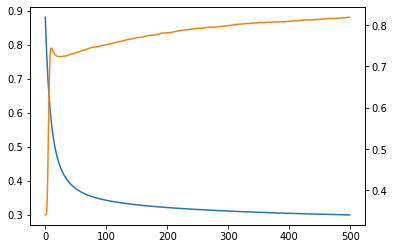

In [ ]:
#@title
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('log.txt',sep=',',header=None)
fig,ax = plt.subplots()
ax.plot(data[0],label="logloss")
ax2=ax.twinx()
ax2.plot([], [])
ax2.plot(data[1],label="accuracy")
plt.show()

Best accuracy: 0.818800
Wall time: 1.43 s
with learning rate = 0.1 and nb_epochs=500

# Debugging
Compile with debugging info on the host (`-g`) and device (`-G`).


In [ ]:
!nvcc -g -G -I /usr/local/cuda/samples/common/inc/ -L/usr/local/cuda/include -lcublas -lcusolver linear_classification.cu  read_csv.cu preprocess_data.cu evaluate_accuracy.cu fmatrix.cu classifier_math.cu cuda_stuff.cu

Run the debugger cuda-gdb, stopping at the first error that is detected. Shows first the call stack on the GPU, the values of local variables, then the call stack on the host (thread 1).

In [ ]:
! printf "set cuda memcheck on\nset cuda api_failures stop\ncatch throw\nr\nbt\ninfo locals\nthread 1\nbt\n" > tmp.txt
! cat tmp.txt
! cuda-gdb -batch -x tmp.txt ./a.out

set cuda memcheck on
set cuda api_failures stop
catch throw
r
bt
info locals
thread 1
bt
Catchpoint 1 (throw)
[tcsetpgrp failed in terminal_inferior: Inappropriate ioctl for device]
[tcsetpgrp failed in terminal_inferior: Inappropriate ioctl for device]
[Thread debugging using libthread_db enabled]
Using host libthread_db library "/lib/x86_64-linux-gnu/libthread_db.so.1".
[tcsetpgrp failed in terminal_inferior: Inappropriate ioctl for device]
headers: "longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"!
Read 17000 rows.
Allocated memory for inputs: 17000 rows, 9 columns.
Allocated memory for labels: 17000 rows, 2 columns.
Inputs (first 10):
1	1	1	1	1	1	1	1	1	1	
-114.31	-114.47	-114.56	-114.57	-114.57	-114.58	-114.58	-114.59	-114.59	-114.6	
34.19	34.4	33.69	33.64	33.57	33.63	33.61	34.83	33.61	34.83	
15	19	17	14	20	29	25	41	34	46	
5612	7650	720	1501	1454	1387	2907	812	4789	1497	
1283	1901	174	337	326	23

In [ ]:
!cuda-memcheck ./a.out 

========= CUDA-MEMCHECK
headers: "longitude","latitude","housing_median_age","total_rooms","total_bedrooms","population","households","median_income","median_house_value"!
Read 17000 rows.
Allocated memory for inputs: 17000 rows, 9 columns.
Allocated memory for labels: 17000 rows, 2 columns.
Inputs (first 10):
1	1	1	1	1	1	1	1	1	1	
-114.31	-114.47	-114.56	-114.57	-114.57	-114.58	-114.58	-114.59	-114.59	-114.6	
34.19	34.4	33.69	33.64	33.57	33.63	33.61	34.83	33.61	34.83	
15	19	17	14	20	29	25	41	34	46	
5612	7650	720	1501	1454	1387	2907	812	4789	1497	
1283	1901	174	337	326	236	680	168	1175	309	
1015	1129	333	515	624	671	1841	375	3134	787	
472	463	117	226	262	239	633	158	1056	271	
1.4936	1.82	1.6509	3.1917	1.925	3.3438	2.6768	1.7083	2.1782	2.1908	
Labels (first 10):
0	0	0	0	0	0	0	0	0	0	
1	1	1	1	1	1	1	1	1	1	
initial accuracy: 0.340200
iter: 0, logloss: 0.880316, accuracy: 0.340000
iter: 1, logloss: 0.830006, accuracy: 0.340200
iter: 2, logloss: 0.785198, accuracy: 0.342600
iter: 3, logloss: 0